## Modeling

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show
from bokeh.embed import components
from bokeh.models import CategoricalColorMapper, NumeralTickFormatter
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

np.set_printoptions(suppress=True) # Suppress scientific notation where possible
pd.set_option('display.max_rows', 70)


In [2]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [26]:
# read in pickled data
X_train, X_test = pd.read_pickle('pickle/xtrain.pkl'), pd.read_pickle('pickle/xtest.pkl')
y_train, y_test = pd.read_pickle('pickle/ytrain.pkl'), pd.read_pickle('pickle/ytest.pkl')

X_train_scaled, X_test_scaled = pd.read_pickle('pickle/xtrain_scaled.pkl'), pd.read_pickle('pickle/xtest_scaled.pkl')
# y_train_scaled = y_train

In [27]:
def plot_distribution(df):
    rows, cols = 14, 5
    
    df = df.sample(1000, random_state=71)

    bankrupt_no = df[df.IsBankrupt == 0]
    bankrupt_yes = df[df.IsBankrupt == 1]
    
    plt.subplots(rows,cols,figsize=(50,70))
    
    for index, col in enumerate(df.drop(columns=['IsBankrupt']).columns):
        plt.subplot(rows, cols, index+1)
        sns.distplot(bankrupt_no[col],hist=False,label='No')
        sns.distplot(bankrupt_yes[col],hist=False,label='Yes')
        plt.xticks([])
        plt.yticks([])
        plt.legend(title='Is Bankrupt?')

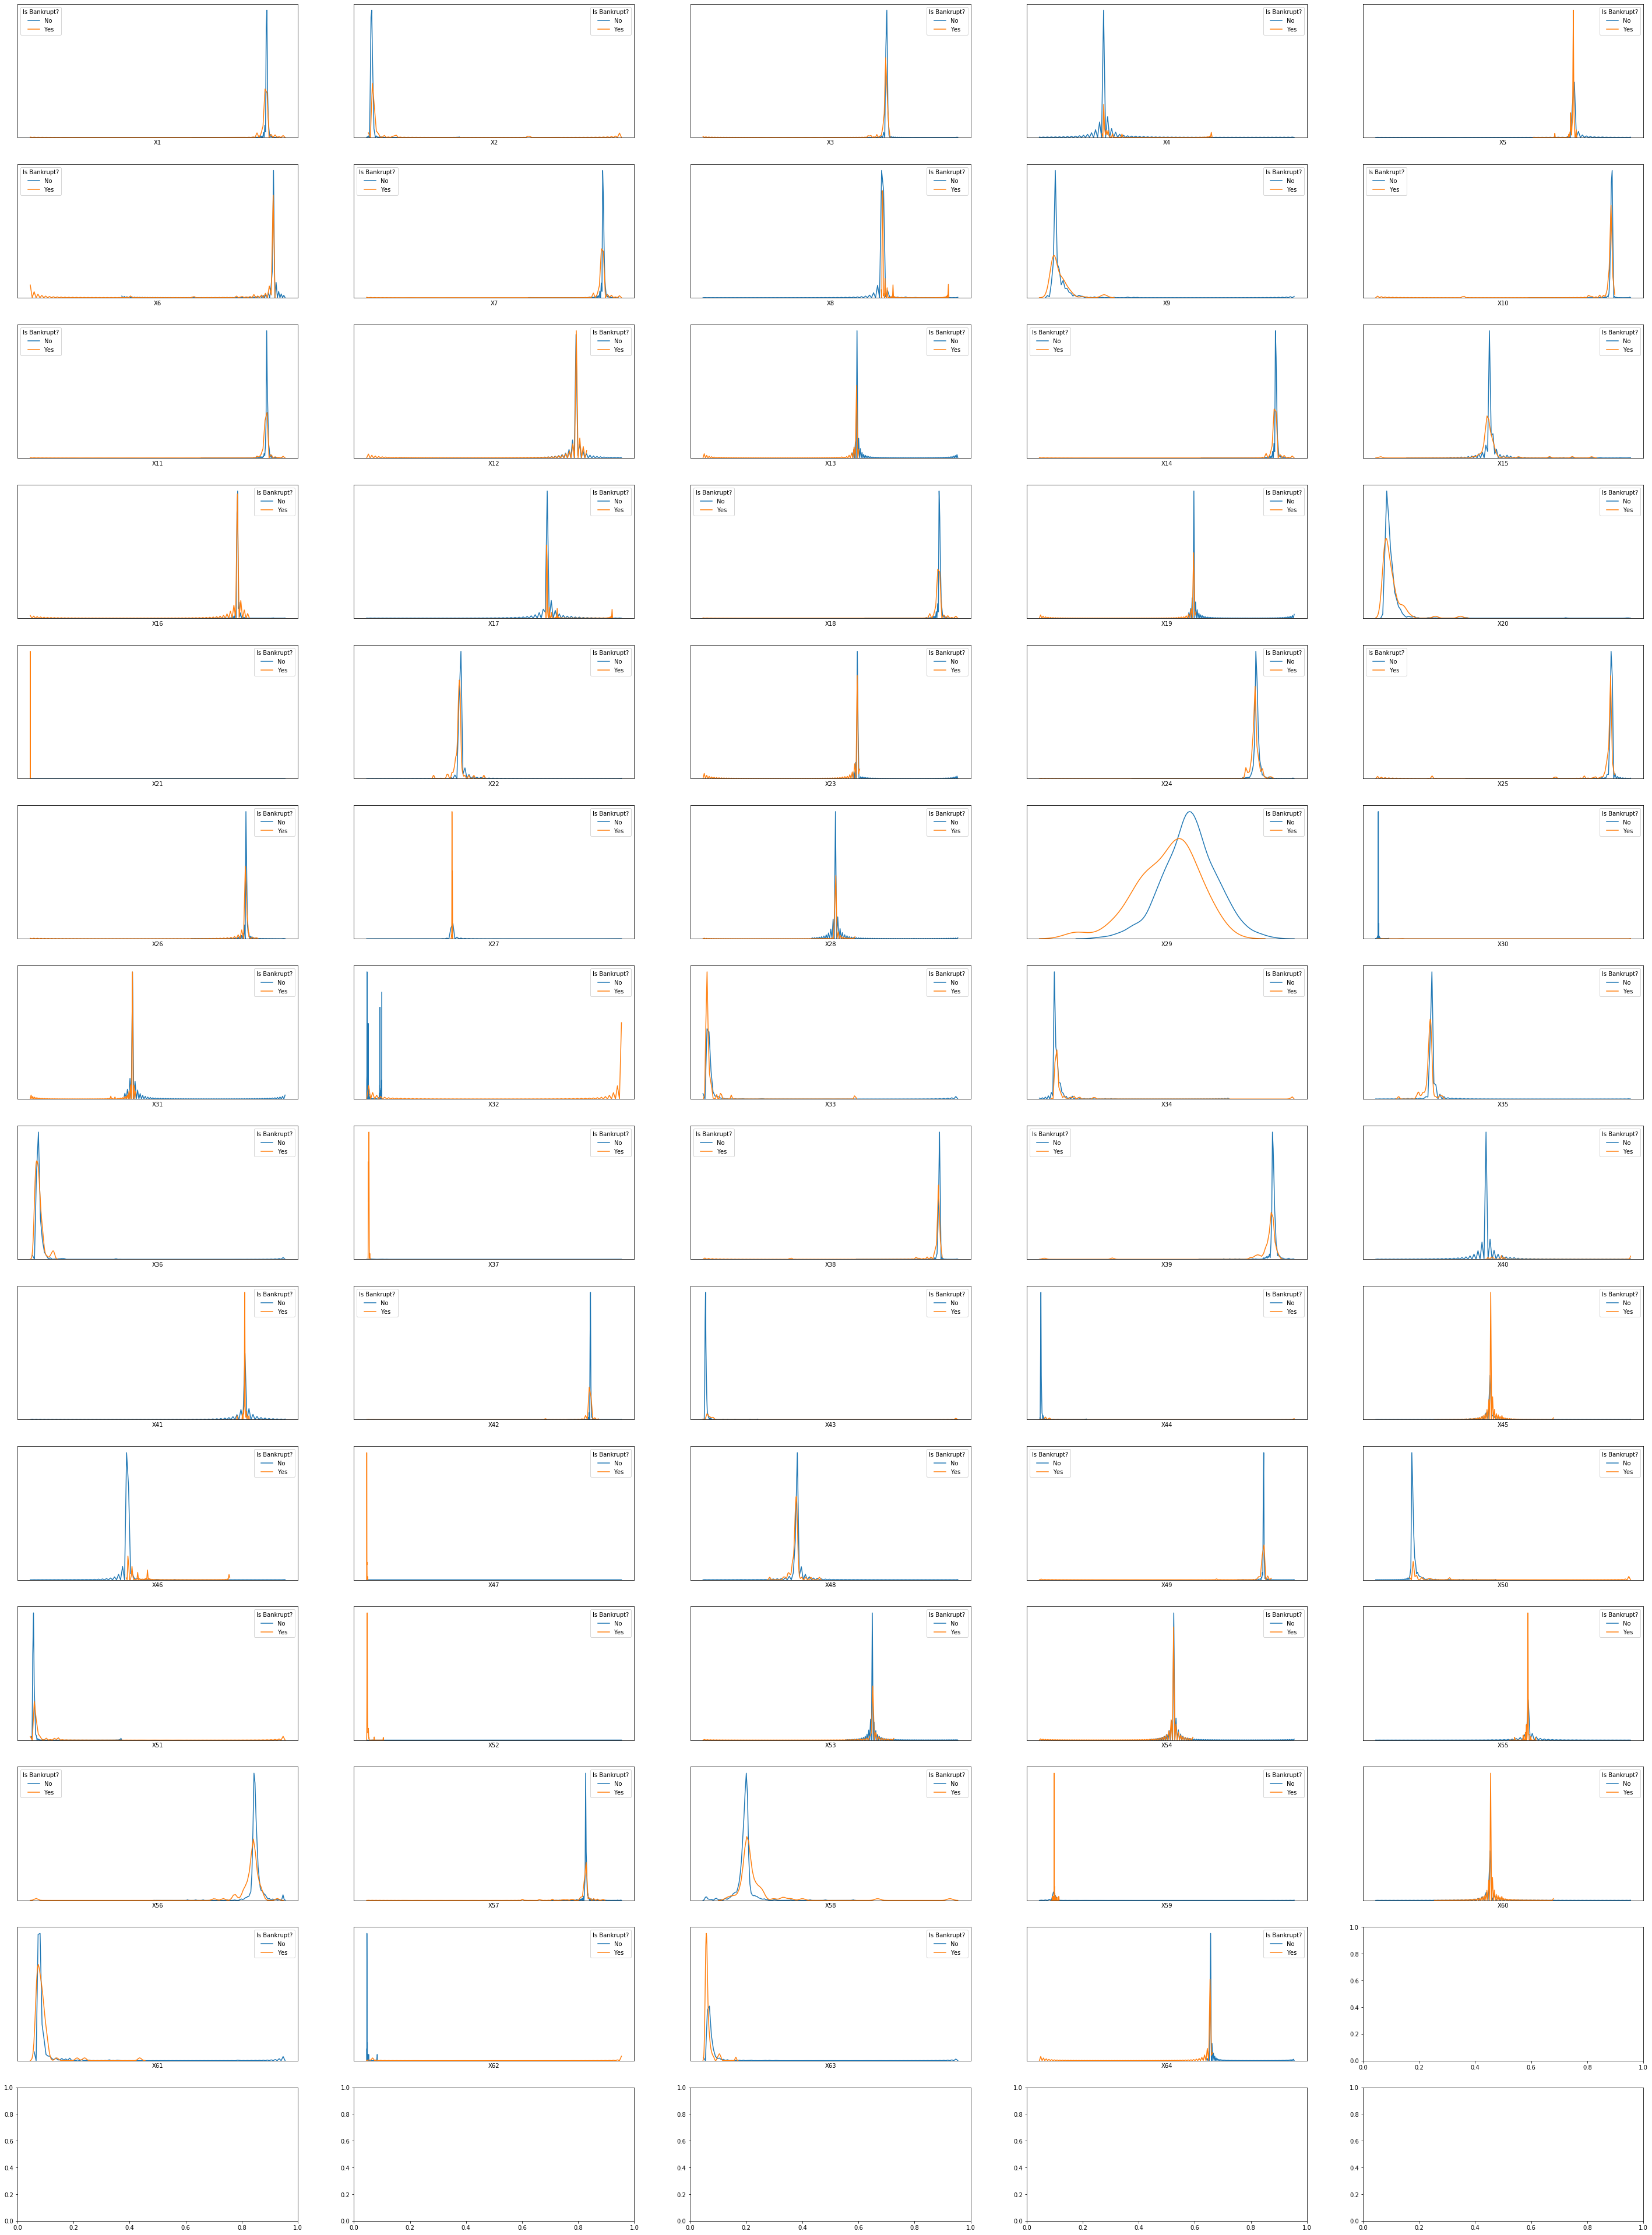

In [30]:
X = X_train.append(X_test).reset_index().drop(columns=['index'])
Y = y_train.append(y_test).reset_index().drop(columns=['index'])
df = pd.concat([X,Y],axis=1)

plot_distribution(df)

In [4]:
# initialize models 
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rf_params = {'n_estimators': [300,400,500,600]
            , 'max_features': ['auto', 'sqrt', 'log2']
            , 'max_depth': [20,30,40,50]
            , 'criterion':['gini', 'entropy']}
xg_params = {'colsample_bytree': [0.5,0.6,0.8,1]
             , 'learning_rate': [0.2,0.3,0.4]
             , 'max_depth': [3,4,5,6,7]
             , 'alpha': [0,0.08,0.01]
             , 'gamma': [0,0.004,0.008,0.01]}

# initialize various classification models
# employ gridsearchcv in tuning parameters
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(solver='lbfgs',max_iter=8000,C=1000)
# lr = GridSearchCV(LogisticRegression(solver='lbfgs',max_iter=6000), lr_params, cv=5)
nb = GaussianNB()
sv = svm.SVC(probability=True)
dt = DecisionTreeClassifier()
# rf = GridSearchCV(RandomForestClassifier(random_state=42,n_jobs=-1), rf_params, cv=5, n_jobs=-1)
rf = RandomForestClassifier(random_state=42,n_jobs=-1,criterion='entropy',max_depth=30,max_features='auto'
                            ,n_estimators=700)
xg = XGBClassifier(alpha=0,colsample_bytree=0.5,gamma=0.01,learning_rate=0.3,max_depth=6)
# xg = XGBClassifier(alpha=0,colsample_bytree=0.5,gamma=0.01,learning_rate=0.3,max_depth=6)
# xg = GridSearchCV(XGBClassifier(), param_grid=xg_params, n_jobs=-1, cv=5)

models = [knn, lr, nb, dt, rf, xg]
model_desc = ['KNN', 'Logistic Regression', 'Naive Bayes', 'Decision Trees', 'Random Forest','XG Boost']
# models = [xg]
# model_desc = ['XG Boost']

In [5]:
def run_models(models,model_desc,Xtrain,ytrain,Xtest,ytest,Xtrain_scaled,Xtest_scaled,sampled=False):
    df_results = pd.DataFrame(columns=['Model','Precision','Recall','F1_CV','F1'])
    
    model_confusions = []
    model_positives = []
    feature_importance_rf = []
    feature_importance_xg = []

    for index, model in enumerate(models):
        print(f'>>>>>>>>>>>> Running {model_desc[index]}')

        # KNN will use the scaled dataset, while the others will use the unscaled one
        if model_desc[index] == 'KNN':
            Xtrain = Xtrain_scaled
            Xtest = Xtest_scaled

        if model_desc[index] == 'XG Boost' and sampled:
            if isinstance(Xtest, pd.DataFrame):
                Xtest = Xtest.values
                
        try:
            ytrain = ytrain.values.ravel()
        except:
            pass
        
        f1_cv = np.mean(cross_val_score(model, Xtrain, ytrain, cv=10, scoring='f1'))
        model.fit(Xtrain, ytrain)

        # predict
        model_predictions = model.predict(Xtest)
        model_probabilities = model.predict_proba(Xtest)

        model_confusions.append(confusion_matrix(ytest, model_predictions))
        model_positives.append(roc_curve(ytest, model_probabilities[:,1]))
        fpr, tpr, thresholds = roc_curve(ytest, model_probabilities[:,1])

        try:
            print(f'Best parameters: {model.best_params_}')
        except:
            pass

        df_results.loc[len(df_results)] = [model_desc[index]
                                          , precision_score(ytest, model_predictions)
                                          , recall_score(ytest, model_predictions)
                                          , f1_cv
                                          , f1_score(ytest, model_predictions)]

    return df_results, model_confusions

Run all models for entire dataset

In [6]:
print(run_models(models,model_desc,X_train,y_train,X_test,y_test,X_train_scaled,X_test_scaled))

>>>>>>>>>>>> Running KNN
>>>>>>>>>>>> Running Logistic Regression


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



>>>>>>>>>>>> Running Naive Bayes
>>>>>>>>>>>> Running Decision Trees
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost
(                 Model  Precision    Recall     F1_CV        F1
0                  KNN   0.366667  0.125000  0.166315  0.186441
1  Logistic Regression   0.285714  0.022727  0.057312  0.042105
2          Naive Bayes   0.350000  0.079545  0.065413  0.129630
3       Decision Trees   0.552941  0.534091  0.580954  0.543353
4        Random Forest   0.838710  0.295455  0.499357  0.436975
5             XG Boost   0.867925  0.522727  0.657389  0.652482, [array([[1075,   19],
       [  77,   11]]), array([[1089,    5],
       [  86,    2]]), array([[1081,   13],
       [  81,    7]]), array([[1056,   38],
       [  41,   47]]), array([[1089,    5],
       [  62,   26]]), array([[1087,    7],
       [  42,   46]])])


XG Boost appears to perform the best. I'll try various oversampling techniques next to address the imbalance in the target.

### Random Oversampling

In [7]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_scaled_resampled, y_scaled_resampled = ros.fit_sample(X_train_scaled,y_train)

print(run_models(models,model_desc,X_resampled,y_resampled,X_test.values,y_test,X_scaled_resampled,X_test_scaled,True))


>>>>>>>>>>>> Running KNN


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



>>>>>>>>>>>> Running Logistic Regression
>>>>>>>>>>>> Running Naive Bayes
>>>>>>>>>>>> Running Decision Trees
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost
(                 Model  Precision    Recall     F1_CV        F1
0                  KNN   0.209040  0.420455  0.934816  0.279245
1  Logistic Regression   0.136519  0.454545  0.631262  0.209974
2          Naive Bayes   0.280000  0.079545  0.158326  0.123894
3       Decision Trees   0.488372  0.477273  0.981098  0.482759
4        Random Forest   0.820513  0.363636  0.994254  0.503937
5             XG Boost   0.857143  0.613636  0.992462  0.715232, [array([[954, 140],
       [ 51,  37]]), array([[841, 253],
       [ 48,  40]]), array([[1076,   18],
       [  81,    7]]), array([[1050,   44],
       [  46,   42]]), array([[1087,    7],
       [  56,   32]]), array([[1085,    9],
       [  34,   54]])])


There is evidence of overfitting for most of the models.

### SMOTE

In [8]:
X_smote, y_smote = SMOTE(random_state=42).fit_sample(X_train,y_train)
X_smote_scaled, y_smote_scaled = SMOTE(random_state=42).fit_sample(X_train_scaled,y_train)

print(run_models(models,model_desc,X_smote,y_smote,X_test.values,y_test,X_smote_scaled,X_test_scaled,True))


>>>>>>>>>>>> Running KNN


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



>>>>>>>>>>>> Running Logistic Regression


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



>>>>>>>>>>>> Running Naive Bayes
>>>>>>>>>>>> Running Decision Trees
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost
(                 Model  Precision    Recall     F1_CV        F1
0                  KNN   0.172414  0.511364  0.870291  0.257880
1  Logistic Regression   0.142539  0.727273  0.674022  0.238361
2          Naive Bayes   0.074173  0.943182  0.605489  0.137531
3       Decision Trees   0.347107  0.477273  0.938388  0.401914
4        Random Forest   0.626506  0.590909  0.979286  0.608187
5             XG Boost   0.779412  0.602273  0.985345  0.679487, [array([[878, 216],
       [ 43,  45]]), array([[709, 385],
       [ 24,  64]]), array([[  58, 1036],
       [   5,   83]]), array([[1015,   79],
       [  46,   42]]), array([[1063,   31],
       [  36,   52]]), array([[1079,   15],
       [  35,   53]])])


Smote shows evidence of overfitting as well.

### ADASYN

In [9]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)
X_adasyn_scaled, y_adasyn_scaled = ADASYN(random_state=42).fit_sample(X_train_scaled,y_train)

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
# X_scaled_resampled, y_scaled_resampled = ros.fit_sample(X_train_scaled,y_train)

print(run_models(models,model_desc,X_adasyn,y_adasyn,X_test.values,y_test,X_adasyn_scaled,X_test_scaled,True))

>>>>>>>>>>>> Running KNN


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



>>>>>>>>>>>> Running Logistic Regression


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



>>>>>>>>>>>> Running Naive Bayes
>>>>>>>>>>>> Running Decision Trees
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost
(                 Model  Precision    Recall     F1_CV        F1
0                  KNN   0.161616  0.545455  0.819914  0.249351
1  Logistic Regression   0.113953  0.556818  0.634243  0.189189
2          Naive Bayes   0.074439  0.943182  0.609167  0.137988
3       Decision Trees   0.416667  0.568182  0.917721  0.480769
4        Random Forest   0.620690  0.613636  0.969666  0.617143
5             XG Boost   0.768116  0.602273  0.980679  0.675159, [array([[845, 249],
       [ 40,  48]]), array([[713, 381],
       [ 39,  49]]), array([[  62, 1032],
       [   5,   83]]), array([[1024,   70],
       [  38,   50]]), array([[1061,   33],
       [  34,   54]]), array([[1078,   16],
       [  35,   53]])])


Given that all three oversampling techniques show evidence of overfitting, I'll go with the one with the best performance, which is Random Oversampling. I'll rerun that and use those results for feature engineering.

I'll also focus on tuning the model with the best performance - XG Boost.

### Feature Engineering

In [10]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_scaled_resampled, y_scaled_resampled = ros.fit_sample(X_train_scaled,y_train)

print(run_models(models,model_desc,X_resampled,y_resampled,X_test.values,y_test,X_scaled_resampled,X_test_scaled,True))


>>>>>>>>>>>> Running KNN


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



>>>>>>>>>>>> Running Logistic Regression
>>>>>>>>>>>> Running Naive Bayes
>>>>>>>>>>>> Running Decision Trees
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost
(                 Model  Precision    Recall     F1_CV        F1
0                  KNN   0.209040  0.420455  0.934816  0.279245
1  Logistic Regression   0.136519  0.454545  0.631262  0.209974
2          Naive Bayes   0.280000  0.079545  0.158326  0.123894
3       Decision Trees   0.451613  0.477273  0.981219  0.464088
4        Random Forest   0.820513  0.363636  0.994254  0.503937
5             XG Boost   0.857143  0.613636  0.992462  0.715232, [array([[954, 140],
       [ 51,  37]]), array([[841, 253],
       [ 48,  40]]), array([[1076,   18],
       [  81,    7]]), array([[1043,   51],
       [  46,   42]]), array([[1087,    7],
       [  56,   32]]), array([[1085,    9],
       [  34,   54]])])


In [11]:
# RF features
features_rf = pd.DataFrame(rf.feature_importances_,index=X_train.columns
             , columns=['importance']).sort_values('importance',ascending=False).reset_index().head(10)

# XG features
features_xg = pd.DataFrame(xg.feature_importances_,index=X_train.columns
             , columns=['importance']).sort_values('importance',ascending=False).reset_index().head(10)
# LR features
features_lr = pd.DataFrame(np.transpose(lr.coef_),index=X_train.columns
             , columns=['importance']).sort_values('importance',ascending=False).reset_index().head(20)

In [12]:
cols = X_train.columns

In [13]:
set(features_rf.iloc[:,0]) & set(features_xg.iloc[:,0])
# & set(features_lr.iloc[:,0])

{'X13', 'X21', 'X27', 'X34', 'X35', 'X42'}

In [14]:
list(features_xg.iloc[:,0])

['X13', 'X35', 'X55', 'X42', 'X26', 'X21', 'X34', 'X6', 'X27', 'X7']

In [15]:
# xg_params2 = {'colsample_bytree': [0.8]
#              , 'learning_rate': [0.2]
#              , 'max_depth': [9,10]
#              , 'alpha': [0]
#              , 'gamma': [0.02,0.03,0.04]}
# xg2 = GridSearchCV(XGBClassifier(), param_grid=xg_params2, n_jobs=-1, cv=5)
    
xg2 = XGBClassifier(alpha=0,colsample_bytree=0.5,gamma=0.01,learning_rate=0.3,max_depth=6)
models2 = [dt,rf,xg2]
model_desc2 = ['Decsion Tree','Random Forest','XG Boost']

include_in_model = ['X6','X13','X21','X27','X29','X35','X38','X42','X45','X46','X56']
# pd.DataFrame(X_resampled,columns=cols)[include_in_model]
X_resampled_feat = pd.DataFrame(X_resampled,columns=cols)[include_in_model]
X_scaled_resampled_feat = pd.DataFrame(X_scaled_resampled,columns=cols)[include_in_model]
X_test_feat = X_test[include_in_model]
X_test_scaled_feat = X_test_scaled[include_in_model]

results, confusion_xg = run_models(models2,model_desc2,X_resampled_feat,y_resampled,X_test_feat,y_test
                                ,X_scaled_resampled_feat,X_test_scaled_feat)
results

>>>>>>>>>>>> Running Decsion Tree
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost


,Model,Precision,Recall,F1_CV,F1
0,Decsion Tree,0.530864,0.488636,0.982721,0.508876
1,Random Forest,0.800000,0.500000,0.994924,0.615385
2,XG Boost,0.771429,0.613636,0.990009,0.683544


Text(0.5, 0, 'Importance (%)')

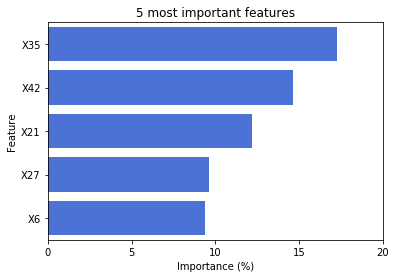

In [16]:
xg2_feat_importance = (pd.DataFrame(xg2.feature_importances_,index=include_in_model
                                 , columns=['Importance']).sort_values('Importance',ascending=False).
                       reset_index().head(5))
xg2_feat_importance = xg2_feat_importance.rename(columns={'index':'Feature'})
xg2_feat_importance['Importance'] = xg2_feat_importance['Importance'] * 100
sns.barplot(x='Importance',y='Feature',data=xg2_feat_importance, color='#3468eb')
plt.title('5 most important features')
plt.xticks([0,5,10,15,20])
plt.xlabel('Importance (%)')

### Visualizing model variance

In [17]:
pca = PCA(n_components=2)
pcomps = pca.fit_transform(X_scaled_resampled_feat)
pDf = pd.DataFrame(data=pcomps, columns=['PC1', 'PC2'])
finalDf = pd.concat([pDf, pd.DataFrame(y_resampled,columns=['IsBankrupt'])], axis=1)
finalDf.head()

,PC1,PC2,IsBankrupt
0,-6738.798699,-103.490131,0
1,-6737.886166,-238.115009,0
2,-6737.608978,-235.423283,0
3,-6737.795067,-237.984526,0
4,-6737.122870,-239.901291,0


In [18]:
finalDf['IsBankrupt'] = finalDf['IsBankrupt'].astype(str)
finalDf.dtypes

PC1           float64
PC2           float64
IsBankrupt     object
dtype: object

In [19]:
finalDf['Temp'] = finalDf['IsBankrupt'].apply(lambda val: 'Not Bankrupt' if val == '0' else 'Bankrupt')
finalDf.sample(3)

,PC1,PC2,IsBankrupt,Temp
8546,-6737.050445,140.402926,1,Bankrupt
5661,-6725.278972,-239.869336,1,Bankrupt
2390,-6737.862537,-235.134397,0,Not Bankrupt


In [20]:
scatterPlot = figure(plot_width=400, plot_height=400)
color_mapper = CategoricalColorMapper(factors = ['0','1'], palette=['#6688EC','#D46666'])
scatterPlot.circle('PC2', 'PC1', source=finalDf, color={'field':'IsBankrupt','transform': color_mapper}
                   ,legend='Temp')

scatterPlot.xaxis.axis_label = 'Principal Component 1'
scatterPlot.yaxis.axis_label = 'Principal Component 2'
scatterPlot.legend.location = 'top_right'
scatterPlot.legend.background_fill_color = '#f9e9b6'
scatterPlot.xaxis[0].formatter = NumeralTickFormatter(format=",0")
scatterPlot.yaxis[0].formatter = NumeralTickFormatter(format=",0")
show(scatterPlot)

In [21]:
X = X_resampled_feat.append(X_test_feat).reset_index().drop(columns=['index'])
Y = pd.DataFrame(y_resampled,columns=['IsBankrupt']).iloc[:,0].append(pd.DataFrame(y_test).iloc[:,0]).reset_index().drop(columns=['index'])
df = pd.concat([X,Y],axis=1)
df['IsBankrupt'] = df['IsBankrupt'].astype(str)
df.head()


,X6,X13,X21,X27,X29,X35,X38,X42,X45,X46,X56,IsBankrupt
0,0.000000,0.279620,1.0504,134.84000,3.3262,0.435460,0.791280,0.247270,1.18850,2.17870,0.234810,0
1,0.072489,0.076205,1.0837,0.21513,4.6746,0.026677,0.629040,0.021601,0.27767,1.70530,-0.004079,0
2,0.042770,0.035367,1.2238,2.90690,6.1164,0.039020,0.505420,0.024476,0.00000,0.44468,0.095794,0
3,0.079064,0.032919,1.1775,0.34565,6.3908,0.046882,0.843450,0.033461,0.18620,0.65839,0.031931,0
4,0.008784,-0.086999,1.3134,-1.57110,4.2465,-0.109020,0.011615,-0.069093,-0.48612,0.23103,-0.080365,0


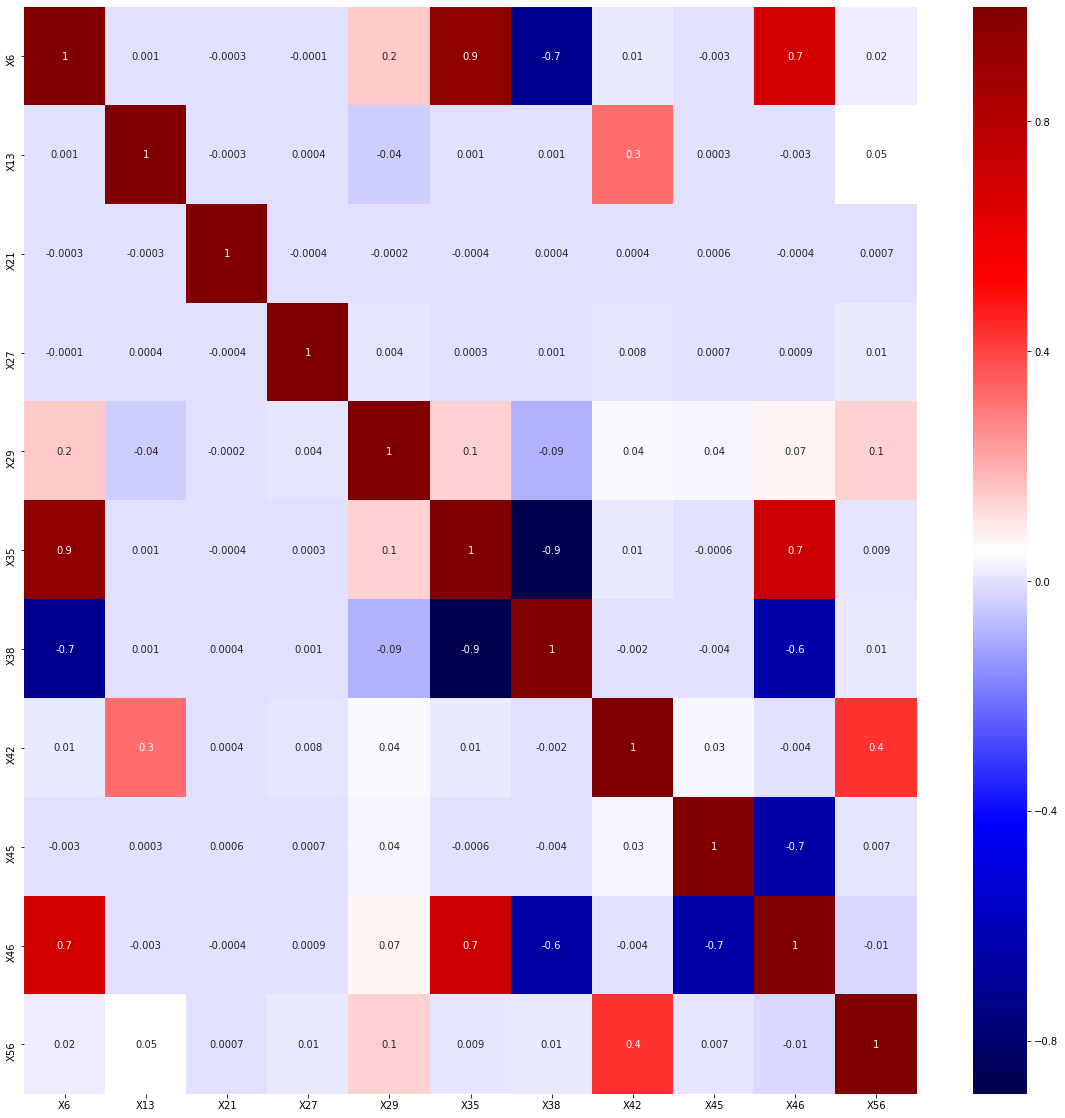

In [22]:
plt.figure(figsize=(20,20))
sns.heatmap(X_resampled_feat.append(X_test_feat).corr(),cmap='seismic',annot=True,fmt='.1g')
# sns.heatmap(data[include_in_model].corr(),cmap='seismic',annot=True,fmt='.1g')

In [23]:
X = X_resampled_feat.append(X_test_feat)
Y = pd.DataFrame(y_resampled).iloc[:,0].append(pd.DataFrame(y_test).iloc[:,0])
XY = pd.concat([X.reset_index(),Y.reset_index()],axis=1)
XY.head()

,index,X6,X13,X21,X27,X29,X35,X38,X42,X45,X46,X56,index,0
0,0,0.000000,0.279620,1.0504,134.84000,3.3262,0.435460,0.791280,0.247270,1.18850,2.17870,0.234810,0,0
1,1,0.072489,0.076205,1.0837,0.21513,4.6746,0.026677,0.629040,0.021601,0.27767,1.70530,-0.004079,1,0
2,2,0.042770,0.035367,1.2238,2.90690,6.1164,0.039020,0.505420,0.024476,0.00000,0.44468,0.095794,2,0
3,3,0.079064,0.032919,1.1775,0.34565,6.3908,0.046882,0.843450,0.033461,0.18620,0.65839,0.031931,3,0
4,4,0.008784,-0.086999,1.3134,-1.57110,4.2465,-0.109020,0.011615,-0.069093,-0.48612,0.23103,-0.080365,4,0


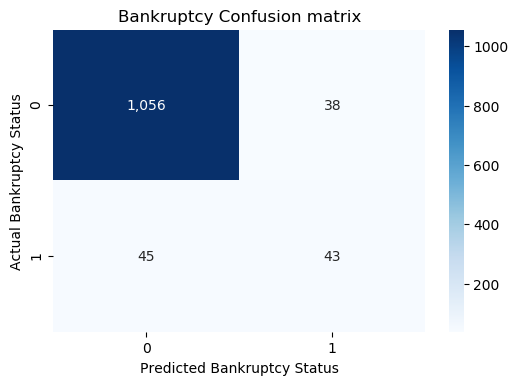

In [24]:
def draw_confusion_heatmap(confusion):
    plt.figure(dpi=100)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt=',d', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted Bankruptcy Status')
    plt.ylabel('Actual Bankruptcy Status')
    plt.title('Bankruptcy Confusion matrix')
    
draw_confusion_heatmap(confusion_xg[0])